In [1]:
%run /work/jupyter_notebooks/index_hgt/base_functions.ipynb
%cd /work/kelsey/hgt

/work/kelsey/hgt


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import subprocess
import itertools
from copy import deepcopy

plotly_accession = open('/Users/thiberio/plotly_accession').read().split()
ptl.sign_in(plotly_accession[0], plotly_accession[1])

In [3]:
if not os.path.isdir('reconciliation_aggregates'):
    os.mkdir('reconciliation_aggregates')
for folder in os.listdir('ranger/'):
    if os.path.isfile('reconciliation_aggregates/%s' % folder):
        continue
    os.system('cp ranger/%s/aggregated reconciliation_aggregates/%s' % (folder, folder))

In [4]:
if not os.path.isdir('renamed_gene_tree'):
    os.mkdir('renamed_gene_tree')

for treefile in os.listdir('gene_trees/'):
    if not treefile.endswith('.treefile'):
        continue
    if os.path.isfile('renamed_gene_tree/%s' % treefile):
        continue
    
    tmp_tree = ete3.Tree('gene_trees/%s' % treefile)
    for leaf in tmp_tree.get_leaves():
        if leaf.name.count('_') == 1:
            gene, genome = leaf.name.split('_')
        elif leaf.name.count('_') > 1 and re.search('GC[AF]_', leaf.name):
            gene, genome = re.search('^([^.]+).+?(GC[AF]_\d+)', leaf.name, re.M).groups()
        elif leaf.name.count('_') == 2 and re.search('_PRJ', leaf.name):
            gene, genome = re.search('^(.+)_(PRJ.+)$', leaf.name, re.M).groups()
        else:
            print(leaf.name)
        gene = gene.split('.')[0]
        leaf.name = '%s_%s' % (genome.replace('_', ''), gene.replace('_', ''))
    
    tmp_tree.write(outfile='renamed_gene_tree/%s' % treefile, format=0, dist_formatter='%.10f')

In [5]:
ranger_parser = aggregate(reference_tree='species_tree-renamed',
                          gene_tree_folder='renamed_gene_tree/',
                          aggregate_folder='reconciliation_aggregates/',
                          reconciliation_folder='ranger/',
                          overall_tree_support_thresh=20,
                          leaves_allowed=False)

In [73]:
if not os.path.isfile('transfers.tab'):
    transfers = []
    for count, group in enumerate(os.listdir('ranger')):
        if not os.path.getsize('ranger/%s/%s.output1' % (group, group)):
            continue
        transfers.append(ranger_parser.parse_aggregated(group))

    transfer_df = pd.concat([n[0] for n in transfers 
                             if type(n) is not dict], ignore_index=True, axis=0, sort=False)
    transfer_df.loc[:,['ranger_confidence',
                       'ranger_confidence_donor',
                       'ranger_confidence_recipient']] = transfer_df.loc[:,['ranger_confidence',
                                                                            'ranger_confidence_donor',
                                                                            'ranger_confidence_recipient']] / 50

    transfer_df.to_csv('transfers.tab', sep='\t')
else:
    transfer_df = pd.read_csv('transfers.tab', sep='\t', index_col=0)

print(transfer_df.shape)
transfer_df.head()

(20523, 9)


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
0,92.0,n53,m18,1.0,1.00,1.00,n112,m19,1422_AAM72683.1-GCA_000006985.1
1,25.0,n97,m61,1.0,1.00,1.00,n71,m81,1422_AAM72683.1-GCA_000006985.1
2,49.0,n96,m38,1.0,0.84,1.00,n47,m92,1422_AAM72683.1-GCA_000006985.1
3,99.0,n76,m103,1.0,0.58,0.58,n79,m104,1422_AAM72683.1-GCA_000006985.1
4,98.0,n57,m35,1.0,0.56,0.50,n80,m36,1422_AAM72683.1-GCA_000006985.1


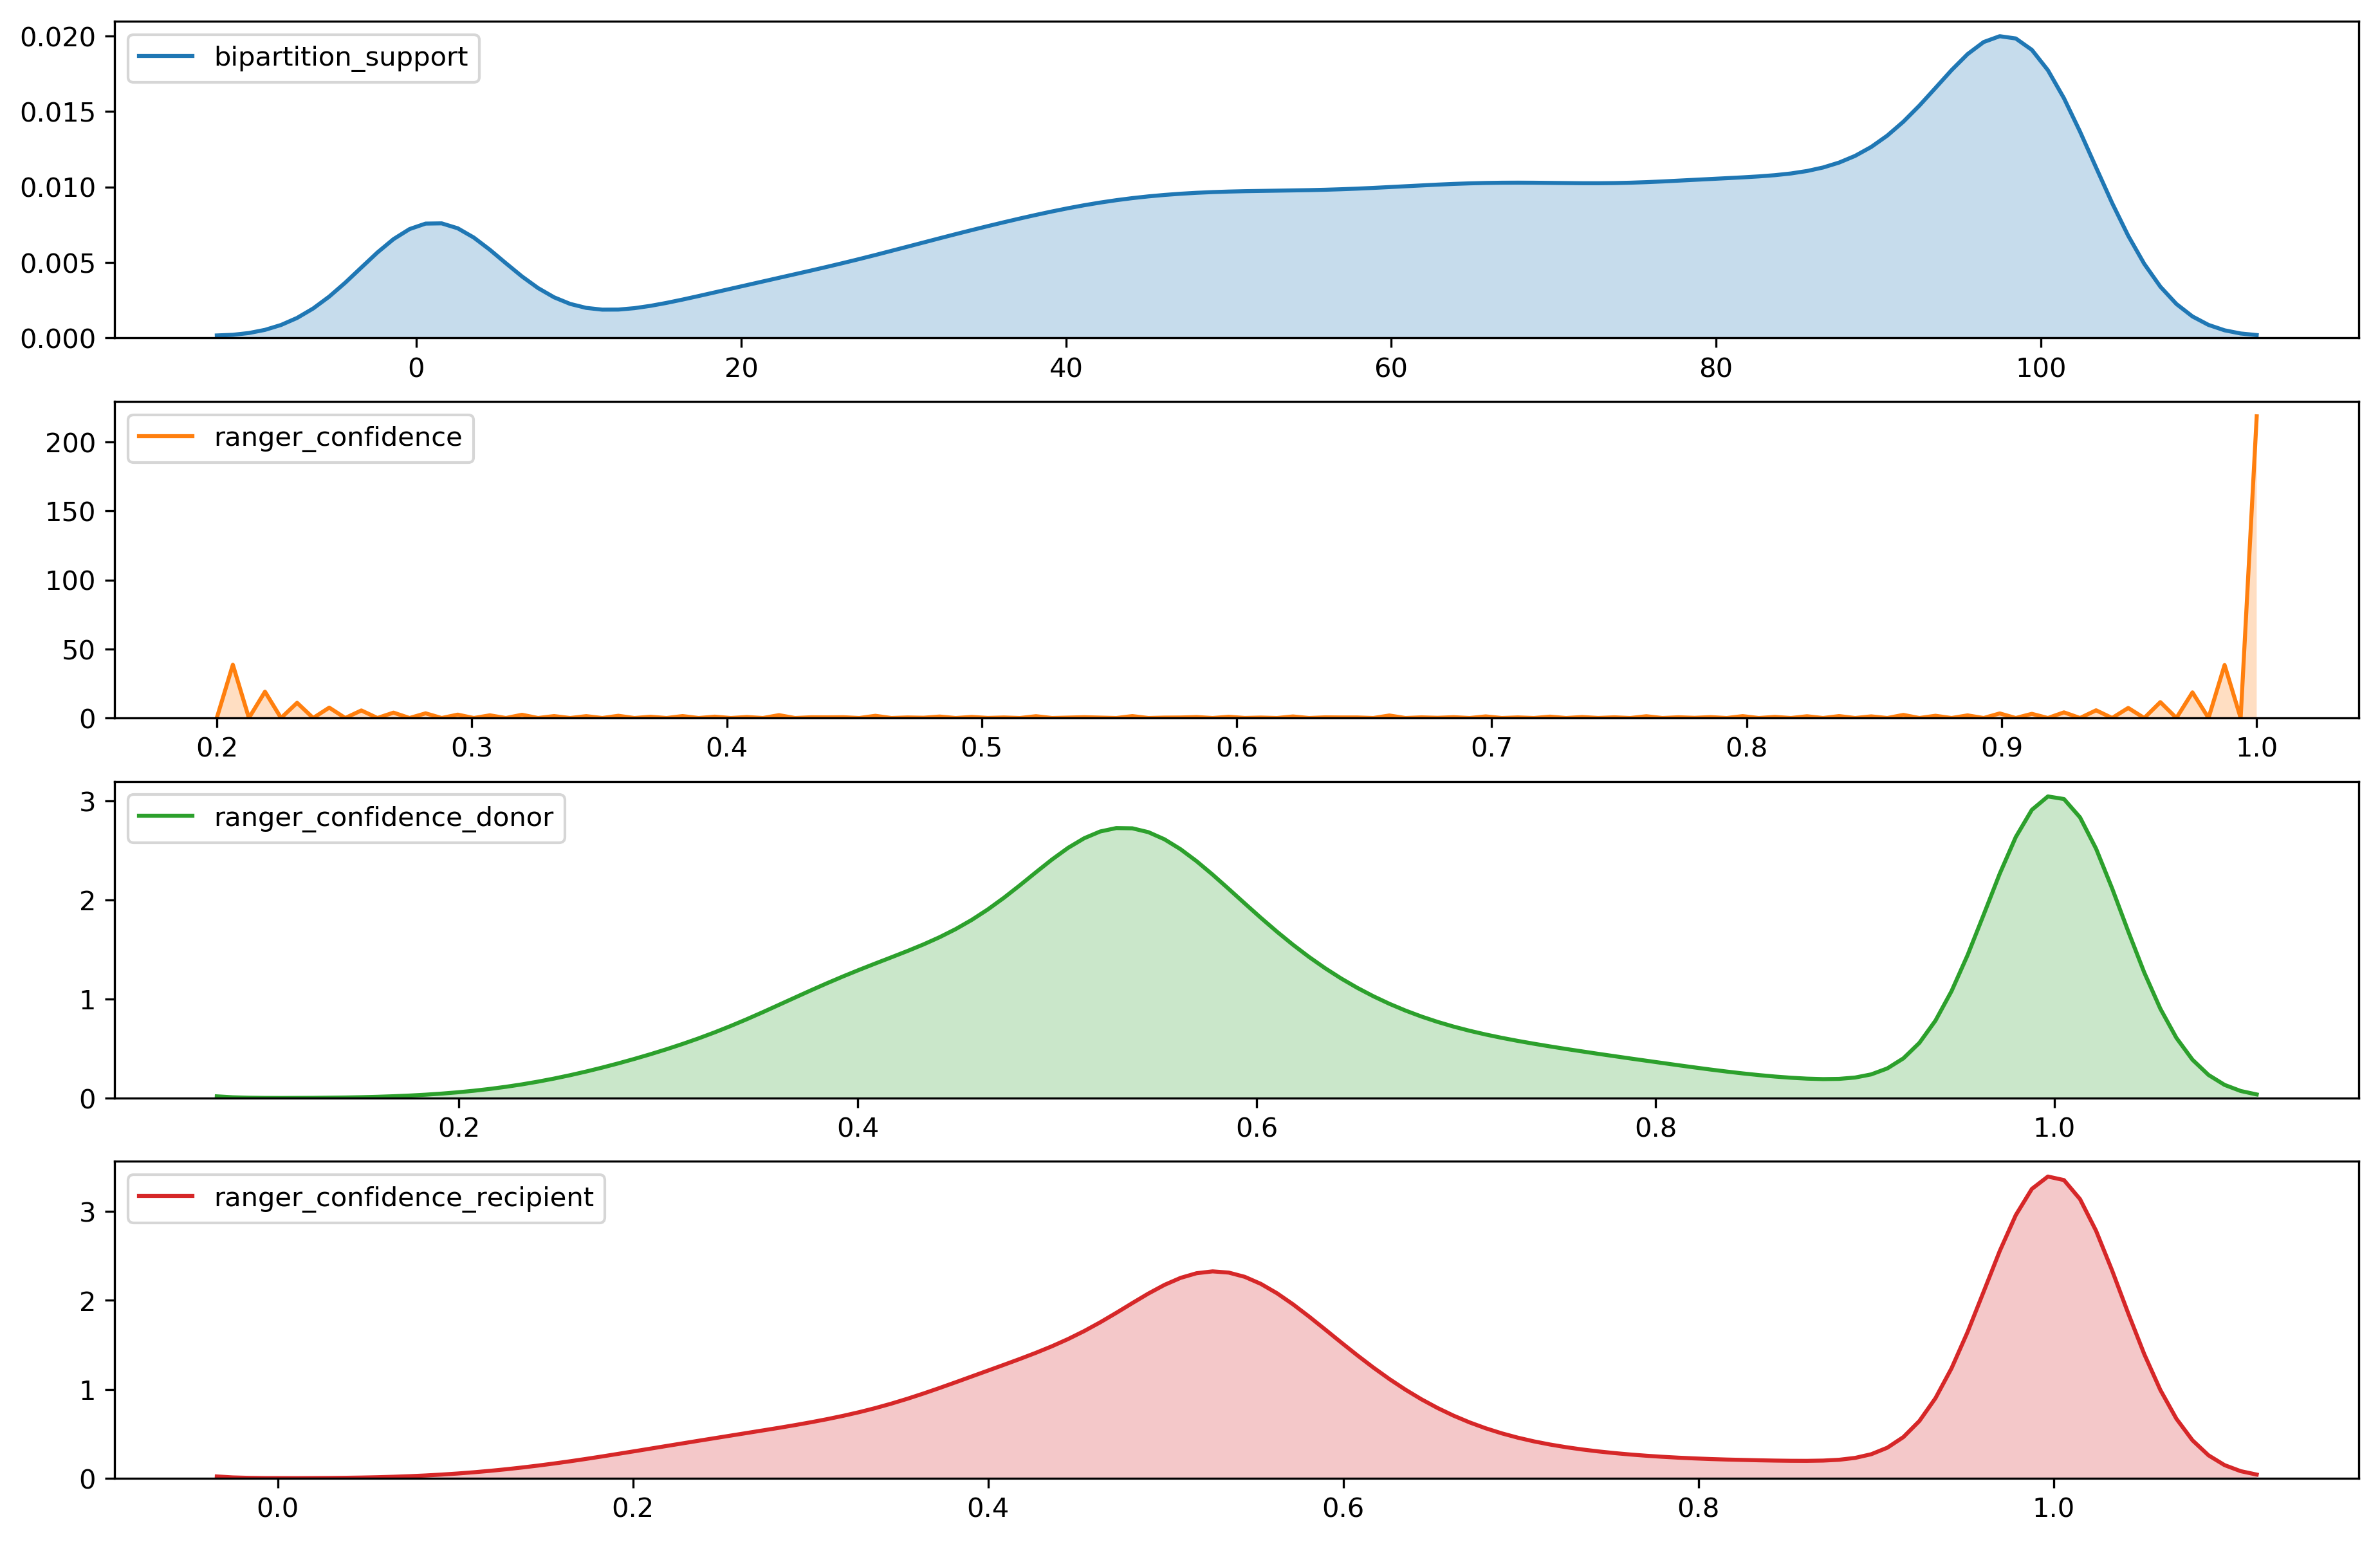

In [7]:
fig, axs = plt.subplots(nrows=4, figsize=(15,10), dpi=300)
colors   = sns.color_palette(n_colors=4).as_hex()
for row, column in enumerate(['bipartition_support', 
                              'ranger_confidence',
                              'ranger_confidence_donor',
                              'ranger_confidence_recipient']):
    sns.kdeplot(transfer_df[column],
                shade=True, color=colors[row], ax=axs[row])

In [77]:
transfer_df = transfer_df[(transfer_df.bipartition_support        >=95)]
print(transfer_df.shape, len(transfer_df.groupby('donor recipient'.split()).groups))
transfer_df.head()

(4301, 9) 1824


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
3,99.0,n76,m103,1.0,0.58,0.58,n79,m104,1422_AAM72683.1-GCA_000006985.1
4,98.0,n57,m35,1.0,0.56,0.50,n80,m36,1422_AAM72683.1-GCA_000006985.1
5,100.0,n119,m131,1.0,0.66,0.66,n123,m132,1422_AAM72683.1-GCA_000006985.1
21,100.0,n76,m75,1.0,1.00,1.00,n79,m76,4468_BAB72593.1-GCA_000009705.1
24,100.0,n56,m13,1.0,0.58,1.00,n111,m19,4468_BAB72593.1-GCA_000009705.1


In [78]:
transfer_df = transfer_df[(transfer_df.ranger_confidence_donor    >=0.8)]
print(transfer_df.shape, len(transfer_df.groupby('donor recipient'.split()).groups))
transfer_df.head()

(1097, 9) 692


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1
50,100.0,n153,m60,1.0,1.0,1.0,n158,m64,8868_BAB76993.1-GCA_000009705.1
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1


In [79]:
transfer_df = transfer_df[(transfer_df.ranger_confidence_recipient    >=0.8)]
print(transfer_df.shape, len(transfer_df.groupby('donor recipient'.split()).groups))
transfer_df.head()

(815, 9) 526


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1
50,100.0,n153,m60,1.0,1.0,1.0,n158,m64,8868_BAB76993.1-GCA_000009705.1
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1


In [9]:
ranger_parser.name_species_tree_nodes(
    reconciliation_file='ranger/4468_BAB72593.1-GCA_000009705.1/4468_BAB72593.1-GCA_000009705.1.output1'
)

In [ ]:
ranger_parser.species_tree.write(outfile='species_tree_named_nodes',
                               format=1,
                               dist_formatter='%.10f')

In [ ]:
out = open('maxtic.input', 'w')
for index, row in transfer_df[['donor', 'recipient']].iterrows():
    out.write('%s\n' % '\t'.join(row.tolist()))
out.close()

In [ ]:
subprocess.call(['python2.7',
                 '/work/ale/maxtic/MaxTiC.py',
                 'species_tree_named_nodes',
                 'maxtic.input',
                 'ls=180'])

In [10]:
donor_recipient_pairs = []
for line in open('maxtic.input_MT_output_partial_order').readlines():
    donor_recipient_pairs.append('-'.join(line.split()[:2]))

transfer_df['donor-recipient'] = transfer_df['donor']+'-'+transfer_df['recipient']
transfer_df = transfer_df[transfer_df['donor-recipient'].isin(donor_recipient_pairs)]
transfer_df.drop(labels='donor-recipient', axis=1, inplace=True)
transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 21 to 20461
Data columns (total 9 columns):
bipartition_support            623 non-null float64
donor                          623 non-null object
donor_map                      623 non-null object
ranger_confidence              623 non-null float64
ranger_confidence_donor        623 non-null float64
ranger_confidence_recipient    623 non-null float64
recipient                      623 non-null object
recipient_map                  623 non-null object
family                         623 non-null object
dtypes: float64(4), object(5)
memory usage: 48.7+ KB


In [11]:
extended_df = ranger_parser.assess_transfer_distance(transfer_df)
extended_df = ranger_parser.assess_dtl_cost(extended_df)

print(extended_df.shape)
extended_df.head()

(623, 17)


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1,0.217616,16.0,4.0,16.0,6.0,4.000000,2.666667,1.222222
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1,0.454789,13.0,2.0,19.0,2.0,6.500000,9.500000,0.750000
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1,1.180305,5.0,3.0,3.0,110.0,1.666667,0.027273,2.000000
128,96.0,n165,m326,1.0,1.0,1.0,n168,m330,1446_AAM72707.1-GCA_000006985.1,0.096659,8.0,2.0,10.0,2.0,4.000000,5.000000,0.500000


In [12]:
backup = extended_df.copy()

In [55]:
extended_df = backup.copy()

extended_df['donor_ancestry'] = extended_df.apply(
    lambda row:\
    [ancestor.name for ancestor in next(
        ranger_parser.species_tree.iter_search_nodes(name=row.donor)).get_ancestors()],
    axis=1)
extended_df['recipient_ancestry'] = extended_df.apply(
    lambda row:\
    [ancestor.name for ancestor in next(
        ranger_parser.species_tree.iter_search_nodes(name=row.recipient)).get_ancestors()],
    axis=1)
extended_df.head()

,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio,donor_ancestry,recipient_ancestry
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000,"[n75, n74, n70, n50, n49, n46, n44, n11, n10, ...","[n78, n77, n75, n74, n70, n50, n49, n46, n44, ..."
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1,0.217616,16.0,4.0,16.0,6.0,4.000000,2.666667,1.222222,"[n100, n99, n96, n80, n74, n70, n50, n49, n46,...","[n104, n99, n96, n80, n74, n70, n50, n49, n46,..."
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1,0.454789,13.0,2.0,19.0,2.0,6.500000,9.500000,0.750000,"[n75, n74, n70, n50, n49, n46, n44, n11, n10, ...","[n107, n106, n105, n104, n99, n96, n80, n74, n..."
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1,1.180305,5.0,3.0,3.0,110.0,1.666667,0.027273,2.000000,"[n143, n142, n141, n127, n1]","[n3, n2, n1]"
128,96.0,n165,m326,1.0,1.0,1.0,n168,m330,1446_AAM72707.1-GCA_000006985.1,0.096659,8.0,2.0,10.0,2.0,4.000000,5.000000,0.500000,"[n164, n162, n160, n159, n157, n141, n127, n1]","[n167, n166, n164, n162, n160, n159, n157, n14..."


In [56]:
clusters = []
for name, row in extended_df.iterrows():
    matching_transfers = extended_df[(
                (extended_df.donor_ancestry.apply(lambda x: row.donor in x)) |
                (extended_df.donor == row.donor)
            ) &
            (
                (extended_df.recipient_ancestry.apply(lambda x: row.recipient in x)) |
                (extended_df.recipient == row.recipient)
            )].index
    existing_cluster = False
    for index, cluster in enumerate(clusters):
        if not cluster.isdisjoint(matching_transfers):
            existing_cluster = True
            clusters[index].update(matching_transfers)
            break
    if not existing_cluster:
        clusters.append(set(matching_transfers))

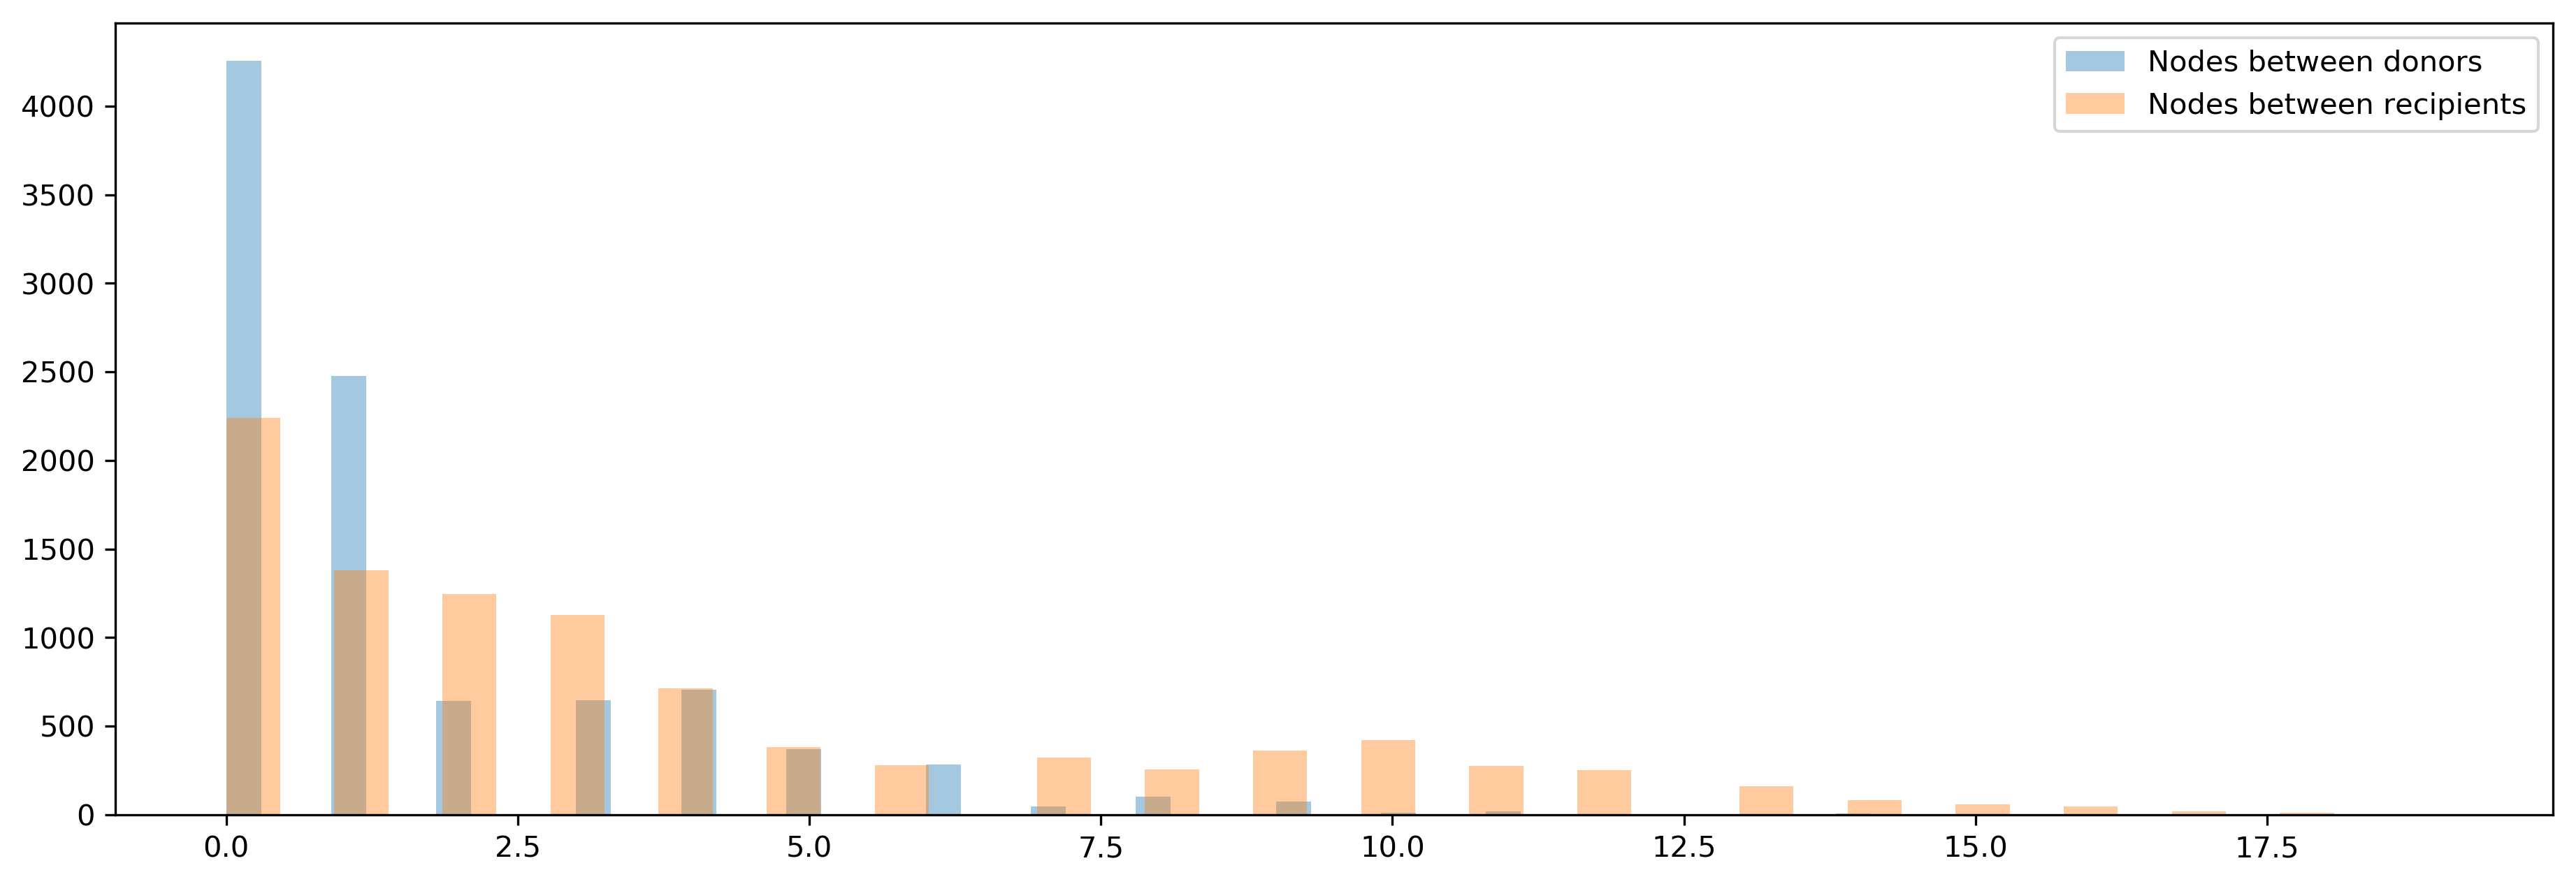

In [153]:
fig, ax             = plt.subplots(figsize=(15, 5), dpi=300)
cluster_count       = 0
donor_distances     = []
recipient_distances = []
for cluster in clusters:
    if len(cluster) < 4:
        continue
    for pair in itertools.combinations(cluster, 2):
        donor1 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[0], 'donor']))
        donor2 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[1], 'donor']))
        donor_distances.append(
            ranger_parser.species_tree.get_distance(donor1, donor2, topology_only=True)
        )

        recipient1 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[0], 'recipient']))
        recipient2 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[1], 'recipient']))
        recipient_distances.append(
            ranger_parser.species_tree.get_distance(recipient1, recipient2, topology_only=True)
        )
    
sns.distplot(donor_distances, kde=False, ax=ax, label='Nodes between donors')
sns.distplot(recipient_distances, kde=False, ax=ax, label='Nodes between recipients')
ax.legend()

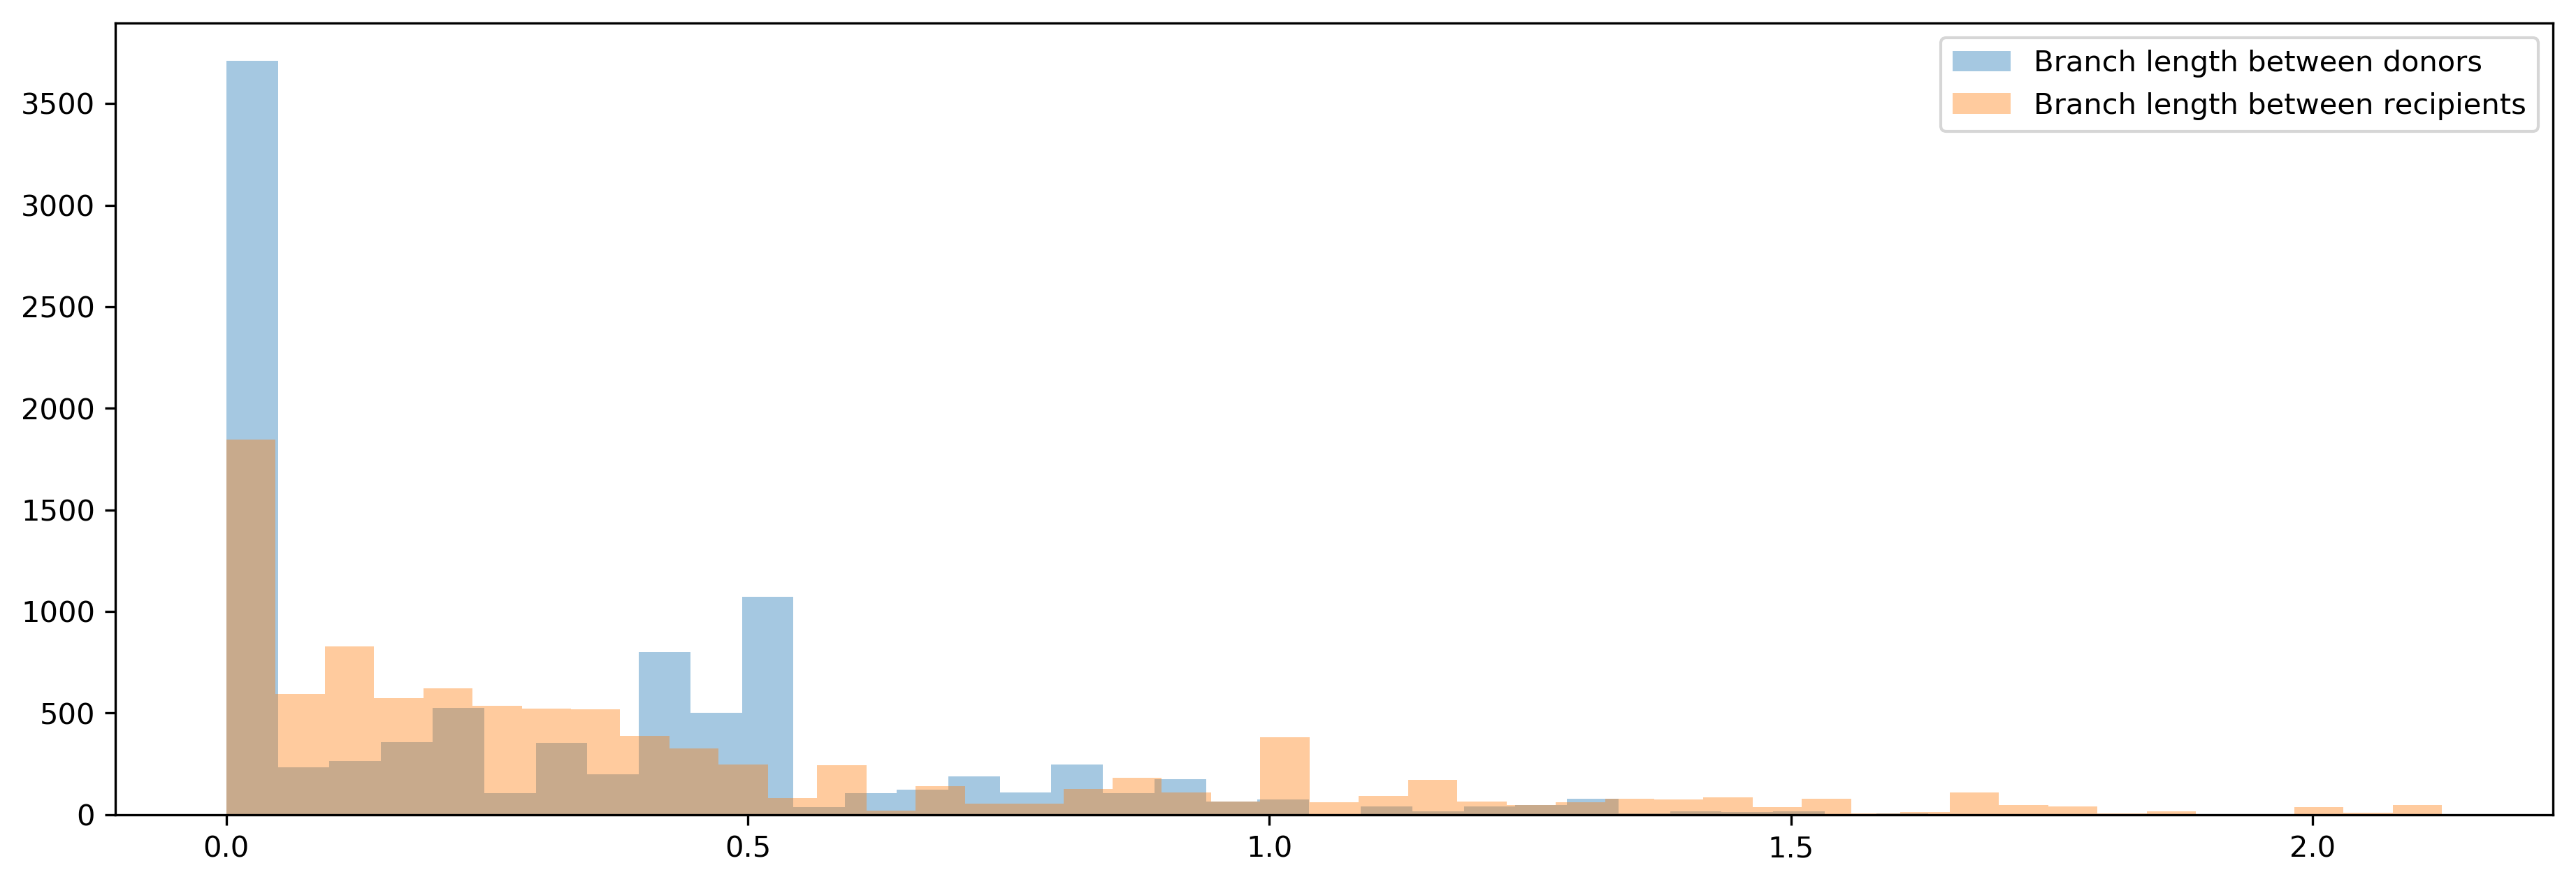

In [154]:
fig, ax             = plt.subplots(figsize=(15, 5), dpi=300)
cluster_count       = 0
donor_distances     = []
recipient_distances = []
for cluster in clusters:
    if len(cluster) < 4:
        continue
    for pair in itertools.combinations(cluster, 2):
        donor1 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[0], 'donor']))
        donor2 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[1], 'donor']))
        donor_distances.append(
            ranger_parser.species_tree.get_distance(donor1, donor2, topology_only=False)
        )

        recipient1 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[0], 'recipient']))
        recipient2 = next(ranger_parser.species_tree.iter_search_nodes(name=extended_df.loc[pair[1], 'recipient']))
        recipient_distances.append(
            ranger_parser.species_tree.get_distance(recipient1, recipient2, topology_only=False)
        )
    
sns.distplot(donor_distances, kde=False, ax=ax, label='Branch length between donors')
sns.distplot(recipient_distances, kde=False, ax=ax, label='Branch length between recipients')
ax.legend()

In [283]:
count = 80
print(extended_df.loc[clusters[count], 'donor'].unique())
print()
print(extended_df.loc[clusters[count], 'recipient'].unique())

['n165']

['n163']


In [284]:
clusters[80]

{5480, 5787, 6758, 8398}

In [282]:
#define constraints for each cluster
def myLayout(node):
    node.img_style["vt_line_color"] = "#000000"
    node.img_style["hz_line_color"] = "#000000"
    node.img_style["vt_line_width"] = 1
    node.img_style["hz_line_width"] = 1
    
    if node.is_leaf():
        node.img_style['size'] = 0
    else:
        if node.ranger_name in possible_donors and node.ranger_name in possible_recipients:
            node.img_style['fgcolor'] = 'purple'
        elif node.ranger_name in possible_donors:
            node.img_style['fgcolor'] = 'red'
        elif node.ranger_name in possible_recipients:
            node.img_style['fgcolor'] = 'green'
        else:
            node.img_style['size'] = 0

treeStyle                    = ete3.TreeStyle()
treeStyle.layout_fn          = myLayout
treeStyle.show_leaf_name     = False
treeStyle.branch_vertical_margin = 1.5

for count, cluster in enumerate(clusters):
    if len(cluster) < 4:
        continue
    tmp_tree = ranger_parser.species_tree.copy()
    
    possible_donors       = set(extended_df.loc[cluster, 'donor'    ].unique().tolist())
    donor_constrainer     = possible_donors.pop()
    constrainer_depth     = extended_df.loc[extended_df.donor==donor_constrainer,
                                            'donor_depth'].tolist()[0]
    for donor in possible_donors:
        tmp_depth = extended_df.loc[extended_df.donor==donor, 'donor_depth'].tolist()[0]
        if tmp_depth > constrainer_depth:
            constrainer_depth = tmp_depth
            donor_constrainer = donor

    possible_recipients   = set(extended_df.loc[cluster, 'recipient'].unique().tolist())
    recipient_constrainer = possible_recipients.pop()
    constrainer_depth     = extended_df.loc[extended_df.recipient==recipient_constrainer,
                                            'recipient_depth'].tolist()[0]
    for recipient in possible_recipients:
        tmp_depth = extended_df.loc[extended_df.recipient==recipient, 'recipient_depth'].tolist()[0]
        if tmp_depth < constrainer_depth:
            constrainer_depth = tmp_depth
            recipient_constrainer = recipient
    
    possible_donors       = set(extended_df.loc[cluster, 'donor'    ].unique().tolist())
    possible_recipients   = set(extended_df.loc[cluster, 'recipient'].unique().tolist())

    treeStyle                    = ete3.TreeStyle()
    treeStyle.layout_fn          = myLayout
    treeStyle.show_leaf_name     = False
    treeStyle.branch_vertical_margin = 1.5
    treeStyle.title.add_face(ete3.TextFace("cluster: %i" % count, fsize=10), column=0)
    tree_plot = tmp_tree.render('hgt_clusters/cluster_%i.png' % count,
                                tree_style=treeStyle, dpi=1200, w=2000, units='px')
    
    #print(count, donor_constrainer, recipient_constrainer)

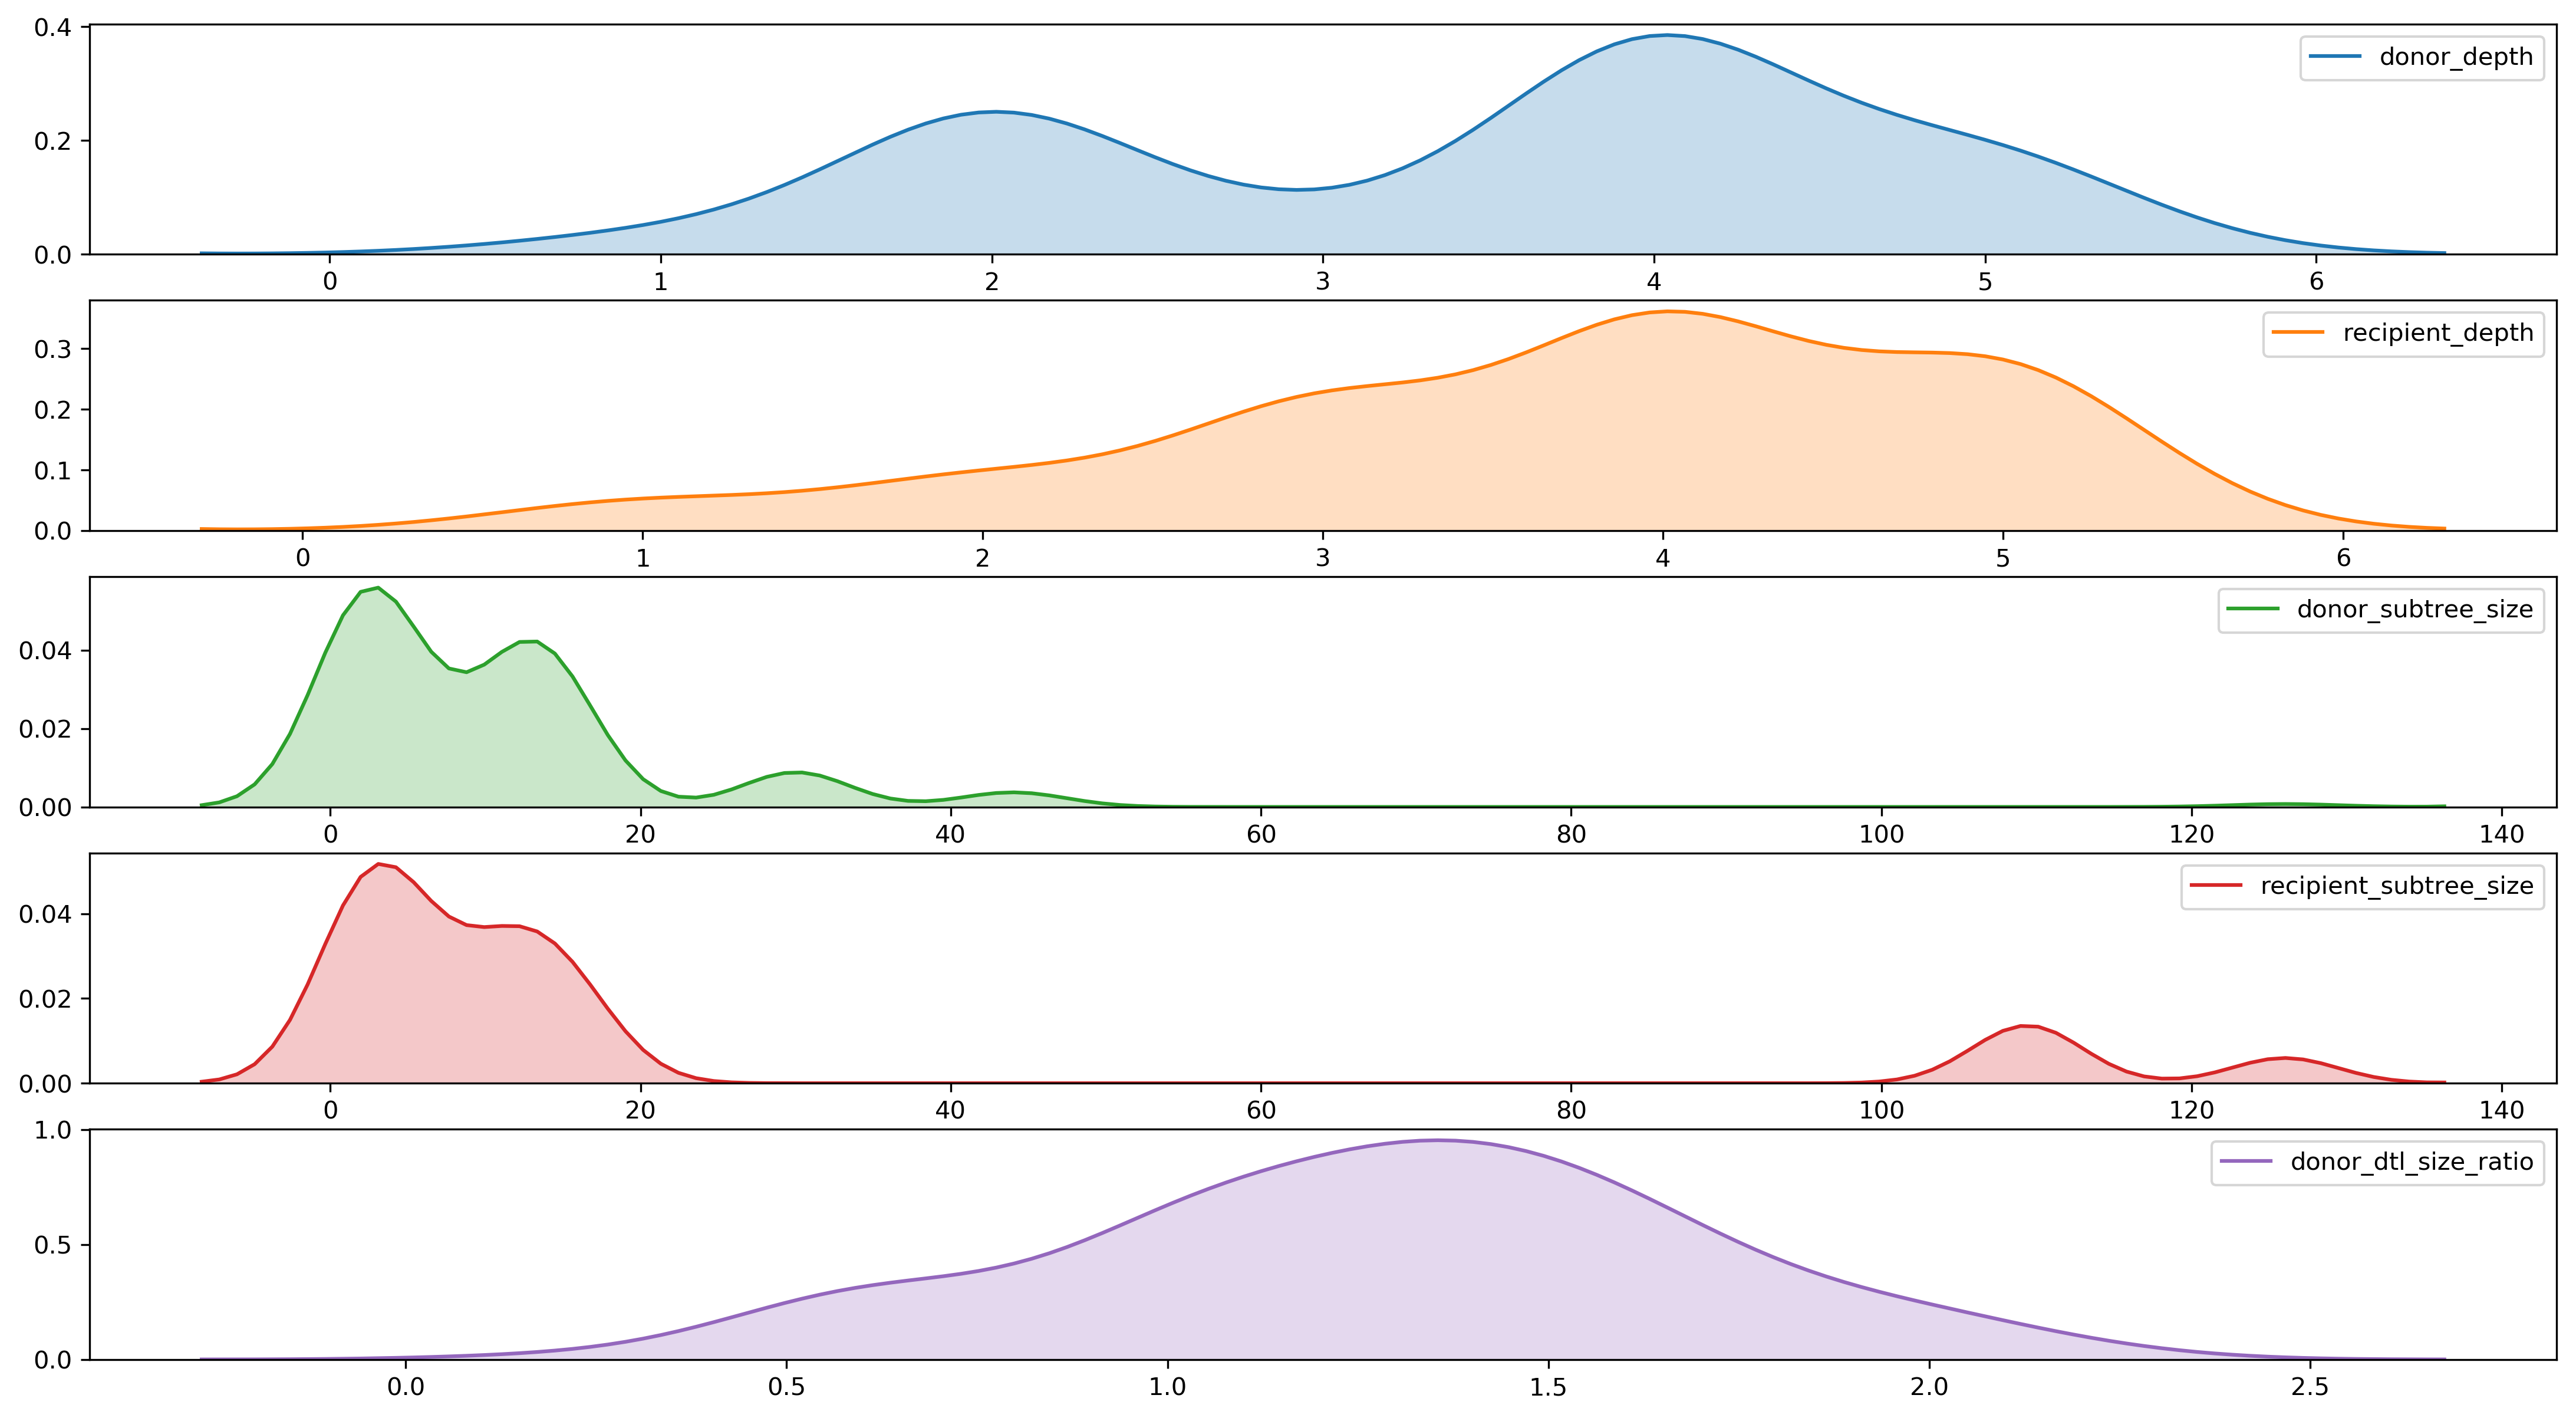

In [13]:
fig, axs = plt.subplots(nrows=5, figsize=(18,10), dpi=300)
colors   = sns.color_palette(n_colors=5).as_hex()
for row, column in enumerate(['donor_depth', 
                              'recipient_depth',
                              'donor_subtree_size',
                              'recipient_subtree_size',
                              'donor_dtl_size_ratio']):
    sns.kdeplot(extended_df.loc[(extended_df.donor_depth<=5)&(extended_df.recipient_depth<=5),
                                column],
                shade=True, color=colors[row], ax=axs[row])

In [15]:
extended_df = ranger_parser.map_taxonomic_level(extended_df, taxa_table='../genomes.tab')
extended_df.head()

,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio,transfer_level
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000,phylum
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1,0.217616,16.0,4.0,16.0,6.0,4.000000,2.666667,1.222222,phylum
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1,0.454789,13.0,2.0,19.0,2.0,6.500000,9.500000,0.750000,phylum
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1,1.180305,5.0,3.0,3.0,110.0,1.666667,0.027273,2.000000,superkingdom
128,96.0,n165,m326,1.0,1.0,1.0,n168,m330,1446_AAM72707.1-GCA_000006985.1,0.096659,8.0,2.0,10.0,2.0,4.000000,5.000000,0.500000,genus


In [16]:
phylum_transfers = extended_df.loc[extended_df.transfer_level == 'phylum']
kingdom_transfers = extended_df.loc[(extended_df.transfer_level == 'kingdom') |
                                    (extended_df.transfer_level == 'superkingdom')]

In [17]:
gregs_table      = pd.read_excel('TimeCalibratingHGTList_7_10.xlsx')
useful_transfers = gregs_table.loc[gregs_table['Use?']=='Y', 'd/r pair'].tolist()
useful_transfers = extended_df.reindex(index=useful_transfers, copy=True)
useful_transfers.dropna(axis=0, how='all', inplace=True)

In [66]:
pwd

'/work/kelsey/hgt'

In [69]:
%%add_to aggregate
def visualize_in_gene_figtree(self, df, taxa_table=None):
    ncbi     = ete3.NCBITaxa()

    taxa_df = pd.read_csv(taxa_table, sep='\t')
    taxa_df['Unnamed: 0'] = taxa_df['Unnamed: 0'].apply(lambda x: x.split('.')[0])
    taxa_df['accession'] = taxa_df['accession'].apply(lambda x: x.split('.')[0])
    taxa_df.set_index('Unnamed: 0', inplace=True)
    
    folder = 'highlighted_gene_trees'
    if not os.path.isdir(folder):
        os.mkdir(folder)
    else:
        os.system('rm -rf %s/*' % folder)
    
    for group in df.family.unique():
        group_df = df.query('family==@group')
        group_num   = int(group.split('_')[0])
        newick_text = open('gene_trees/%s.treefile.rooted' % group).read()
        gene_tree   = ete3.Tree(re.sub('\[.*\];$', ';', newick_text.strip(), flags=re.M))
        for leaf in gene_tree.get_leaves():
            if leaf.name.count('_') == 1:
                gene, genome = leaf.name.split('_')
            elif leaf.name.count('_') > 1 and re.search('GC[AF]_', leaf.name):
                gene, genome = re.search('^([^.]+).+?(GC[AF]_\d+)', leaf.name, re.M).groups()
            elif leaf.name.count('_') == 2 and re.search('_PRJ', leaf.name):
                gene, genome = re.search('^(.+)_(PRJ.+)$', leaf.name, re.M).groups()
            else:
                print(leaf.name)
            gene = gene.split('.')[0]
            leaf.add_feature('true_name', leaf.name)
            leaf.add_feature('genome', genome)
            leaf.name = '%s_%s' % (genome.replace('_', ''), gene.replace('_', ''))
        
        tmp = self.name_branches_as_reconciliation(open('ranger/%s/%s.output1' % (group, group)).read(),
                                                   gene_tree)
        out  = open('%s/group_%i-hgt.figTree' % (folder, group_num), 'w')
        out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(gene_tree))
        branch_names = {}
        for count, node in enumerate(tmp[0].traverse()):

            if node.is_leaf():
                if node.genome in taxa_df.index:
                    node_name = node.genome
                elif node.genome in taxa_df.accession.values:
                    node_name = taxa_df.query('accession==@node.genome').index[0]
                else:
                    out.write('\t%s\n' %(node.true_name))
                    continue

                comment = ['source_name="%s"' % taxa_df.loc[node_name, 'Organism']]
                if pd.isnull(taxa_df.loc[node_name, 'taxid']):
                    out.write('\t%s ' %(node.name))
                else:
                    taxid = taxa_df.loc[node_name, 'taxid']
                    lineage = {j:i
                               for i, j in ncbi.get_rank(
                                   ncbi.get_lineage(taxid)).items()
                              }
                    lineage_names = ncbi.get_taxid_translator(lineage.values())

                    out.write('\t%s ' % (node.name))
                    for rank in ['class', 'phylum', 'order', 'family']:
                        if rank in lineage:
                            comment.append('tax_%s="%s"' % (rank, lineage_names[lineage[rank]]))
                out.write('[&%s]\n' %' '.join(comment))

            else:
                branch_names['_branch_%i_' % count] = '&ranger_name=%s' %(node.ranger_name)
                as_donor     = {}
                as_recipient = {}
                for index, row in group_df.query('donor_map==@node.ranger_name').iterrows():
                    if not row.family.split('_')[0] in as_donor:
                        as_donor[row.family.split('_')[0]] = ''
                    as_donor[row.family.split('_')[0]] += '#%i' % index
                for index, row in group_df.query('recipient_map==@node.ranger_name').iterrows():
                    if not row.family.split('_')[0] in as_recipient:
                        as_recipient[row.family.split('_')[0]] = ''
                    as_recipient[row.family.split('_')[0]] += '#%i' % index

                for group, role in as_donor.items():
                    branch_names['_branch_%i_' % count] += ',role=donor%s' % role
                for group, role in as_recipient.items():
                    if group in as_donor:
                        branch_names['_branch_%i_' % count] += '/recipient%s' % role
                    else:
                        branch_names['_branch_%i_' % count] += ',role=recipient%s' % role

                node.name = '_branch_%i_' % count

        newick_text = tmp[0].write(format=1, dist_formatter='%.10f')
        for key, value in branch_names.items():
            newick_text = newick_text.replace(key, '[%s]' % value)
        out.write(';\nend;\n')
        out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
        out.close()

In [71]:
len(transfer_df.family.unique())

635

In [70]:
ranger_parser.visualize_in_gene_figtree(transfer_df, '../genomes.tab')

In [151]:
ranger_parser.visualize_in_gene_figtree(useful_transfers, '../genomes.tab')

In [ ]:
ranger_parser.interactive_dynamic_plot(
    extended_df)

In [295]:
useful_transfers[useful_transfers.family.str.startswith('21_')].copy()

,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio,transfer_level
18795,99.0,n159,m219,1.0,1.0,1.0,n146,m220,21_AAM71269.1-GCA_000006985.1,0.934148,4.0,12.0,7.0,7.0,0.333333,1.0,1.625,superkingdom


In [305]:
ranger_parser.visualize_in_gene_figtree(useful_transfers[useful_transfers.family.str.startswith('21_')],
                                       '../genomes.tab')

In [ ]:
%%add_to aggregate
def interactive_dynamic_plot(self, df):
    tracers = []
    max_x   = 0
    max_y   = 0
    rank_order = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'kingdom']
    rank_color = dict(zip(rank_order, np.linspace(0,1,15)[1::2]))
    rank_color['superkingdom'] = rank_color['kingdom']

    colors = cl.scales['9']['qual']['Paired']
    colorscale = []
    for pos, value in enumerate(np.linspace(0,1,8)):
        colorscale.append([value, colors[pos]])
        colorscale.append([value, colors[pos+1]])

    for group in df.family.unique():
        tracer = {'x':[], 'y':[], 'text':[], 'marker_color':[], 'marker_size':[]}
        group_number = int(group.split('_')[0])
        for index, row in df.query('family==@group').iterrows():
            corroborated_by = extended_df.query('donor==@row.donor & recipient==@row.recipient').shape[0]
            tracer['x'   ].append(row.donor_recipient_distance)
            tracer['y'   ].append(row['donor_depth/size_ratio'])
            tracer['text'].append('group_%i#%i' % (group_number, index))
            tracer['marker_size'].append(10+corroborated_by*2)
            tracer['marker_color'].append(rank_color[row.transfer_level]
                                          if pd.notnull(row.transfer_level) else 1)
    
        if np.max(tracer['x']) > max_x:
            max_x = np.max(tracer['x'])
        if np.max(tracer['y']) > max_y:
            max_y = np.max(tracer['y'])
        tracer = go.Scatter(x=tracer['x'],
                            y=tracer['y'],
                            mode='markers',
                            text=tracer['text'],
                            name='group_%s' % group.split('_')[0],
                            hoverinfo='text', showlegend=True,
                            marker=dict(size=tracer['marker_size'],
                                        color=tracer['marker_color'],
                                        colorscale=colorscale,
                                        cmax=1,
                                        cmin=0,
                                        symbol='circle',
                                        opacity=0.7)
                           )
        tracers.append(tracer)

    tracers = sorted(tracers, key = lambda x: int(x['name'].split('_')[1]))
    
    layout    = go.Layout(
        title='Interactive index HGT candidates plot!',
        hovermode='closest',
        width=1500, height=1000,
        xaxis=dict(title='Donor-Recipient distance', 
                   autorange=False, 
                   range=[0, max_x+max_x*0.01]),
        yaxis=dict(title='Donor depth/size ratio', 
                   autorange=False, 
                   range=[0, max_y+max_y*0.01]),
        updatemenus=[
            {'buttons':[{'label':'Show all',
                         'method':'restyle',
                         'args': [ 'visible', True]},
                        {'label':'Hide all',
                         'method':'restyle',
                         'args': [ 'visible', ['legendonly']*len(tracers)+[True]]}]}
        ]
    )
    
    tracers.append(go.Scatter(x=[max_x],
                             y=[max_y],
                             mode='markers',
                             name='colorbar',
                             showlegend=False,
                             marker=dict(size=10,
                                        color=0,
                                        symbol='circle',
                                        opacity=0.0,
                                        colorscale=colorscale,
                                        cmin=0,
                                        cmax=1,
                                        colorbar=dict(title='HGT within:',
                                                      x=1.25,
                                                      titleside = 'top',
                                                      tickvals = np.linspace(0,1,15)[1::2],
                                                      ticktext = rank_order,
                                                      ticks = 'outside')
                                        )
                           )
                  )
    
    fig       = go.Figure(data=tracers, layout=layout)
    plot      = plotly.offline.plot(fig, filename='./test.html', auto_open=False)

In [ ]:
#ranger_parser.name_species_tree_nodes(
#    reconciliation_file='ranger/4468_BAB72593.1-GCA_000009705.1/4468_BAB72593.1-GCA_000009705.1.output1'
#)
ranger_parser.visualize_in_figtree(kingdom_transfers, taxa_table='../genomes.tab')